# Analysis Sandbox

## Preliminary

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [37]:
from datetime import datetime
from os import path
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")

from paths import flickr8k_audio_dir

In [4]:
# UTILITY FUNCTIONS

sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))


def ctm_to_dict(ctm_fn):
    """
    Return a dictionary with a list of (start, dur, word) for each utterance.
    """
    ctm_dict = {}
    with open(ctm_fn, "r") as f:
        for line in f:
            utt, _, start, dur, word = line.strip().split(" ")
            if not utt in ctm_dict:
                ctm_dict[utt] = []
            start = float(start)
            dur = float(dur)
            ctm_dict[utt].append((start, dur, word))
    return ctm_dict

## PSyC model output

In [27]:
# ANALYSIS DATA

print datetime.now()

# Filenames
subset = "dev"
model_dir = "models/train_psyc/94a0a7228e"
# model_dir = "models/train_visionsig_psyc/4073c4072c"
options_dict_fn = path.join(model_dir, "options_dict.pkl")
word_to_id_fn = path.join(model_dir, "word_to_id.pkl")
frame_scores_output_dict_fn = path.join(model_dir, "frame_scores_output_dict.{}.pkl".format(subset))

# Load the model options
options_dict_fn = path.join(model_dir, "options_dict.pkl")
print "Reading:", options_dict_fn
with open(options_dict_fn, "rb") as f:
    options_dict = pickle.load(f)

# Load mapping dict
print "Reading:", word_to_id_fn
with open(word_to_id_fn, "rb") as f:
    word_to_id = pickle.load(f)
id_to_word = dict([(i[1], i[0]) for i in word_to_id.iteritems()])

# Load frame scores
print "Reading:", frame_scores_output_dict_fn
with open(frame_scores_output_dict_fn, "rb") as f:
    frame_scores_dict = pickle.load(f)

# Load input data
input_npz_fn = path.join(
        options_dict["speech_data_dir"] if "speech_data_dir" in options_dict
        else options_dict["data_dir"], subset + ".npz"
        )
print "Reading:", input_npz_fn
features_dict = np.load(input_npz_fn)

print datetime.now()

2017-04-26 09:58:43.196770
Reading: models/train_psyc/94a0a7228e/options_dict.pkl
Reading: models/train_psyc/94a0a7228e/word_to_id.pkl
Reading: models/train_psyc/94a0a7228e/frame_scores_output_dict.dev.pkl
Reading: data/mfcc_cmvn_dd_vad/dev.npz
2017-04-26 09:58:43.384123


In [29]:
print "Some keys:", frame_scores_dict.keys()[:10]

Some keys: ['002_3482787182_a5c6d4b386_4', '001_2060031241_a3ae7a06bb_1', '004_3191982761_88793192ed_4', '003_3231880001_193a579b97_3', '002_3047751696_78c2efe5e6_3', '003_2869009633_ea3cafd437_2', '004_3155279929_d1cddbe7cf_1', '003_2596619849_7b635dd310_0', '002_186346360_541047336f_2', '004_1164131282_b30926f332_4']


Length after CNN: 193
(193, 1000)
(1000,)
['field', 'dogs', 'something', 'looking', 'grass']


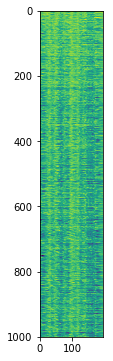

In [47]:
# EXAMPLE

# utt = "001_2060031241_a3ae7a06bb_1"
# utt = "003_2596619849_7b635dd310_0"
# utt = "004_1164131282_b30926f332_4"
utt = "001_1388970365_162edcceb4_1"

# Frame scores
frame_scores_utt = frame_scores_dict[utt]
length = np.min(np.where(np.min(frame_scores_utt, axis=1) == -np.inf)[0])
print "Length after CNN:", length
frame_scores_utt = frame_scores_utt[:length, :]
print frame_scores_utt.shape
plt.imshow(frame_scores_utt.T, interpolation="nearest")
scores = np.max(frame_scores_utt, axis=0)
print scores.shape
ten_max_ids = scores.argsort()[-5:][::-1]
n = 50
n_max_ids = scores.argsort()[-n:][::-1]
print [id_to_word[i] for i in ten_max_ids]


(246, 39)


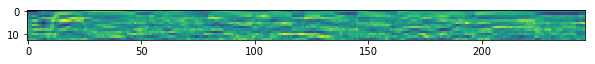

In [48]:
# MFCCs
n_frames = features_dict[utt].shape[0]
print features_dict[utt].shape
plt.imshow(features_dict[utt][:,:13].T, interpolation="nearest")

In [49]:
ctm_fn = path.join(flickr8k_audio_dir, "flickr_8k.ctm")
ctm_dict = ctm_to_dict(ctm_fn)

In [50]:
ctm_entry = ctm_dict[utt[4:-2] + ".jpg_#" + utt[-1]]
print ctm_entry

[(0.29, 0.22, 'THREE'), (0.51, 0.33, 'DOGS'), (0.84, 0.09, 'IN'), (0.93, 0.05, 'A'), (0.98, 0.33, 'FIELD'), (1.31, 0.29, 'LOOKING'), (1.6, 0.07, 'AT'), (1.67, 0.37, 'SOMETHING'), (2.04, 0.09, 'IN'), (2.13, 0.07, 'THE'), (2.2, 0.57, 'GRASS')]


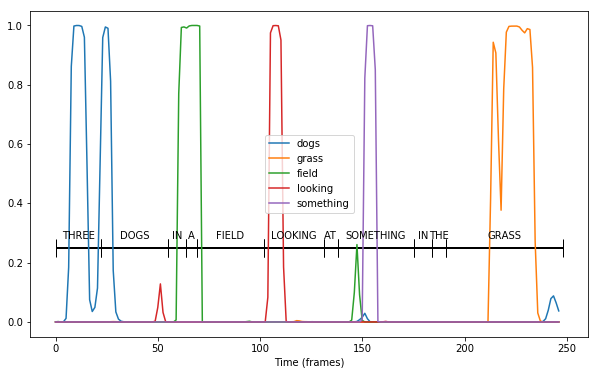

In [51]:
# time = np.arange(length)  # no pooling
time = np.linspace(0, n_frames, num=length)

for word_id, y in enumerate(frame_scores_utt.T):
    if word_id in ten_max_ids:
        plt.plot(time, sigmoid(y), label=id_to_word[word_id])
#     elif word_id in n_max_ids:
#         plt.plot(time, sigmoid(y))

        
        #     else:
#         plt.plot(time, sigmoid(y))

def timelines(y, xstart, xstop, color='b', label=None):
    """Plot timelines at y from xstart to xstop with given color."""   
    plt.hlines(y, xstart, xstop, color, lw=2)
    plt.vlines(xstart, y+0.03, y-0.03, color, lw=1)
    plt.vlines(xstop, y+0.03, y-0.03, color, lw=1)
    if label is not None:
        plt.text(xstart + (xstop-xstart)/2.0, y+0.03, label, horizontalalignment='center')

utt_start = ctm_entry[0][0]
for start, dur, label in ctm_entry:
#     print (start - utt_start)*100.0 #, (start - utt-start + dur)*100.0, label
    timelines(0.25, (start - utt_start)*100.0, (start - utt_start + dur)*100.0, "k", label)

plt.xlabel("Time (frames)")
plt.legend()